In [3]:
import tensorflow as tf
# tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
# logical_gpus = tf.config.experimental.list_logical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K
# from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
# from tensorflow.keras.layers import Conv1D
# from tensorflow.keras.layers import Flatten, Reshape, Lambda
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras import Model

import os
import os.path as osp
import sys
import json

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools_cat
from utils.VAE_model_tools_cat import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle
from scipy.stats import gaussian_kde

import ot

1 Physical GPUs, 1 Logical GPUs


In [4]:
train_output_dir = 'data/plots/cat-tj-0.01-rangeprior-fixed'
# train_output_dir = 'E:/projects/EMD_VAE/data/W-VM-parton-nobatchnorm-uncentered-leaky-dropout-altsched3'
vae_args_file = train_output_dir + '/vae_args.dat'
with open(vae_args_file,'r') as f:
  vae_arg_dict = json.loads(f.read())

latent_dim_lin = vae_arg_dict['latent_dim']
use_vm = False
use_cat = False
if 'latent_dim_vm' in vae_arg_dict:
  latent_dim_vm = vae_arg_dict['latent_dim_vm']
  use_vm = True
  print("Using VM mode")
else:
  print("Not using VM mode")
  latent_dim_vm = 0
if 'cat_dim' in vae_arg_dict:
  latent_dim_cat = vae_arg_dict['cat_dim']
  use_cat = True
  print("Using cat mode")
  if 'cat_priors' in vae_arg_dict:
    prob_a = np.array(vae_arg_dict['cat_priors'])
    a = prob_a / (1-prob_a)
  else:
    prob_a = np.logspace(-3,np.log10(0.5),32)
    a = prob_a / (1-prob_a)
else:
  print("Not using cat mode")
  latent_dim_cat = 0
latent_dim = latent_dim_lin + latent_dim_vm + latent_dim_cat

center = True

Not using VM mode
Using cat mode


In [5]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

def ptetaphiE_to_Epxpypz(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = E
    newjets[:,:,1] = px
    newjets[:,:,2] = py
    newjets[:,:,3] = pz
    
    return newjets

def ptetaphiE_to_ptyphim(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    pz = pt * np.sinh(eta)
    y = 0.5*np.nan_to_num(np.log((E+pz)/(E-pz)))
    
    msqr = np.square(E)-np.square(pt)-np.square(pz)
    msqr[np.abs(msqr) < 1e-6] = 0
    msqr[msqr < 0] = 0
    m = np.sqrt(msqr)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = y
    newjets[:,:,2] = phi
    newjets[:,:,3] = m
    
    return newjets
    
def ptyphim_to_ptetaphiE(jets):
    
    pt = jets[:,:,0]
    y = jets[:,:,1]
    phi = jets[:,:,2]
    m = jets[:,:,3]
    
    eta = np.nan_to_num(np.arcsinh(np.sinh(y)*np.sqrt(1+np.square(m/pt))))
    pz = pt * np.sinh(eta)
    E = np.sqrt(np.square(pz)+np.square(pt)+np.square(m))
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = eta
    newjets[:,:,2] = phi
    newjets[:,:,3] = E
    
    return newjets
    
def center_jets_ptetaphiE(jets):
    cartesian_jets = ptetaphiE_to_Epxpypz(jets)
    sumjet_cartesian = np.sum(cartesian_jets,axis=1)
    
    sumjet_phi = np.arctan2(sumjet_cartesian[:,2],sumjet_cartesian[:,1])
    sumjet_y = 0.5*np.log((sumjet_cartesian[:,0] + sumjet_cartesian[:,-1])/(sumjet_cartesian[:,0] - sumjet_cartesian[:,-1]))
    
    ptyphim_jets = ptetaphiE_to_ptyphim(jets)
    #print(ptyphim_jets[:3,:,:])
    
    transformed_jets = np.copy(ptyphim_jets)
    transformed_jets[:,:,1] = ptyphim_jets[:,:,1] - sumjet_y[:,None]
    transformed_jets[:,:,2] = ptyphim_jets[:,:,2] - sumjet_phi[:,None]
    transformed_jets[:,:,2] = transformed_jets[:,:,2] + np.pi
    transformed_jets[:,:,2] = np.mod(transformed_jets[:,:,2],2*np.pi)
    transformed_jets[:,:,2] = transformed_jets[:,:,2] - np.pi

    transformed_jets[transformed_jets[:,:,0] == 0] = 0
    
    newjets = ptyphim_to_ptetaphiE(transformed_jets)
    return newjets
    
def kl_loss(z_mean, z_log_var):
    return -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    
    
from pyjet import cluster

def get_clustered_pt_eta_phi(pts, locations,R=0.1):
    weights = pts
    outjet = locations
    myjet = np.zeros((weights.shape[-1]),dtype=([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))
    myjet['pT'] = weights
    myjet['eta'] = outjet[:,0]
    myjet['phi'] = outjet[:,1]
    sequence = cluster(myjet,R=R,p=0)
    jets = sequence.inclusive_jets()
    phis = np.array([np.mod(np.pi+jet.phi,2*np.pi)-np.pi for jet in jets])
#     phis = [jet.phi for jet in jets]
    etas = np.array([jet.eta for jet in jets])
    pts = np.array([jet.pt for jet in jets])
    
    return pts, etas, phis


def plot_jets(outs_array, injets = None, numplot = 3, R=0.02,size=50,lim=0.7):
    etalim=5
    #bins=np.linspace(-lim, lim, 126)

    for i in range(numplot):   

        fig, ax = plt.subplots(1, 3,figsize=[15,5],sharey=True)


        outjet = injets[i,:,1:]
        weights = injets[i,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
        ax[0].scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
        ax[0].set_title('Jet'+str(i),y=0.9)

        #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
        for j in range(2):
            outjet = outs_array[j][0][i,:,1:]
            weights = outs_array[j][0][i,:,0]
            pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
            ax[j+1].scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
            ax[j+1].set_title('Sample'+ str(j),y=0.9)
            
        for j in range(3):
            ax[j].set_ylabel(r'$\eta$',fontsize=18)
            ax[j].set_xlabel(r'$\phi$',fontsize=18)
            ax[j].set_ylim([-lim,lim])
            ax[j].set_xlim([-lim,lim])

        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
def plot_KL_logvar(outs_array,xlim=None,ylim=None,showhist=False, numhists=10,hist_ylim=None,hist_xlim=None):

    if use_vm:
      y_pred ,z_mean, z_log_var, losses, _ = outs_array[0]
      KL = losses
    elif use_cat:
      y_pred ,z_mean, z_log_var, _, log_alpha_bern, _ = outs_array[0]

      KL = np.concatenate((kl_loss(z_mean, z_log_var),kl_loss_bern(log_alpha_bern,a)),axis=-1)
      sort_kl_cat = np.flip(np.argsort(np.mean(KL[:,latent_dim_lin:],axis=0)))
    else:
      y_pred ,z_mean, z_log_var, _ = outs_array[0]
      KL = kl_loss(z_mean, z_log_var)

    sort_kl = np.flip(np.argsort(np.mean(KL[:,:latent_dim_lin],axis=0)))

    rms_mean = np.sqrt(np.mean(np.square(z_mean),axis=0))

    if use_vm:
      plt.scatter(np.mean(KL[:,:latent_dim_lin],axis=0),rms_mean[:latent_dim_lin],s=5.)
      plt.scatter(np.mean(KL[:,latent_dim_lin:],axis=0),rms_mean[latent_dim_lin:],s=5.)
    else:
      plt.scatter(np.mean(KL[:,:latent_dim_lin],axis=0),rms_mean,s=5.)
    

    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
        
    plt.xlabel('KL divergence')
    plt.ylabel(r'$\sqrt{\left\langle \mu^2 \right\rangle}$')
    plt.show()
    
    if showhist:
#         for i in range(10):
        plt.hist(np.array(KL)[:,sort_kl[:numhists]],bins=np.linspace(0,20,80),stacked=True)
        #plt.show()
        if hist_ylim:
            plt.ylim(hist_ylim)
        if hist_xlim:
            plt.xlim(hist_xlim)
    if use_cat:
        return sort_kl, sort_kl_cat
    else:
        return sort_kl

def kl_loss_bern_individual(r):
  delta = 1-r
  is_small = np.less(np.abs(delta), 1e-5)
  default_return = (1+r)*np.log(r)/(r-1) - 2
  return np.where(is_small,np.square(delta)/6,default_return)

def kl_loss_bern(log_alpha_bern,a):
  r = a/np.exp(log_alpha_bern)
  kl_separate = kl_loss_bern_individual(r)
  return kl_separate

In [6]:
fn =  'in_data/test_processed.h5'
numparticles = 50
numevents = 500000


# Option 1: Load everything into memory
df = pandas.read_hdf(fn,stop=2000000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

(400000, 201)
Memory in GB: 1.2040138244628906


In [7]:
# Data file contains, for each event, 50 particles (with zero padding), each particle with pT, eta, phi, E.
data = df.values[:,1:].reshape((-1,numparticles,4))
data[data == 1e5] = 0

labels = df.values[:,0]

# Normalize pTs so that HT = 1

center = True
# Center jet (optional)
if center:
    data = center_jets_ptetaphiE(data)
    
HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]
data[:,:,-1] = data[:,:,-1]/HT[:,None]
# Inputs x to NN will be: pT, eta, cos(phi), sin(phi), log E
# Separated phi into cos and sin for continuity around full detector, so make things easier for NN.
# Also adding the log E is mainly because it seems like it should make things easier for NN, since there is an exponential spread in particle energies.
# Feel free to change these choices as desired. E.g. px, py might be equally as good as pt, sin, cos.
sig_input = np.zeros((len(data),numparticles,4))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,2])
sig_input[:,:,3] = np.sin(data[:,:,2])
# sig_input[:,:,4] = np.log(data[:,:,3]+1e-8)


data_x = sig_input
# Event 'labels' y are [pT, eta, phi], which is used to calculate EMD to output which is also pT, eta, phi.
data_y = data[:,:,:3]


train_x = data_x[:numevents]
train_y = data_y[:numevents]
valid_x = data_x[numevents:]
valid_y = data_y[numevents:]

C:\Users\Jack\anaconda3\envs\TensorFlow-GPU\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Jack\anaconda3\envs\TensorFlow-GPU\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


In [8]:
vae, encoder, decoder = build_and_compile_annealing_vae(**vae_arg_dict)

batch_size=10
save_period=2

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_weights_{epoch:02d}.hdf5', save_freq = save_period*5000, save_weights_only=True)
reset_metrics_inst = reset_metrics()

callbacks=[#tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,
            # modelcheckpoint,
            reset_metrics_inst]


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 1024)     5120        inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 50, 1024)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 1024)     1049600     leaky_re_lu[0][0]                
_____

In [9]:
batch_size=100
save_period=2
callbacks=[]

vae.beta.assign(1.)

K.set_value(vae.optimizer.lr,1e-5)


history = vae.fit(x=train_x[:10], y=train_y[:10], batch_size=100,
                epochs=1,verbose=1,#initial_epoch=int(vae.optimizer.iterations/numbatches),
                #validation_data = (valid_x[:10*batch_size],valid_y[:10*batch_size]),
                callbacks = callbacks,steps_per_epoch=1000
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

   1/1000 [..............................] - 0s 21ms/step - loss: 75.9163 - recon_loss: 2.1674 - KL loss: 63.7904 - KL bern loss: 11.0422 - beta: 1.0000 - alpha: 1.0000


In [10]:
#vae.load_weights(train_output_dir + '/model_weights_end_633_3.2e-02.hdf5')
vae.load_weights(train_output_dir + '/model_weights_end_131_4.6e-01.hdf5')

Loss: 3.98e+00
Recon loss: 1.04e-02
KL loss: 1.6258677

KL divergences plot. x axis is ~ log(resolution) for resolution << 1


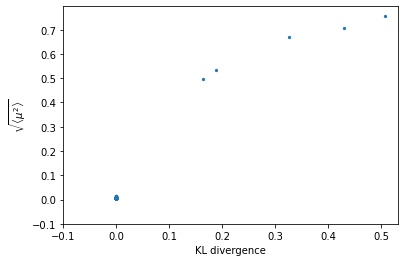

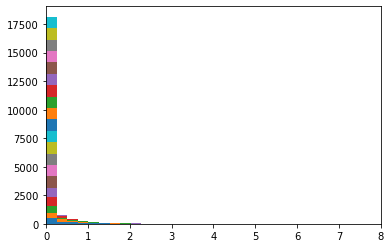

Jet sample plots. Left = original jet. Middle and right: two vae samples


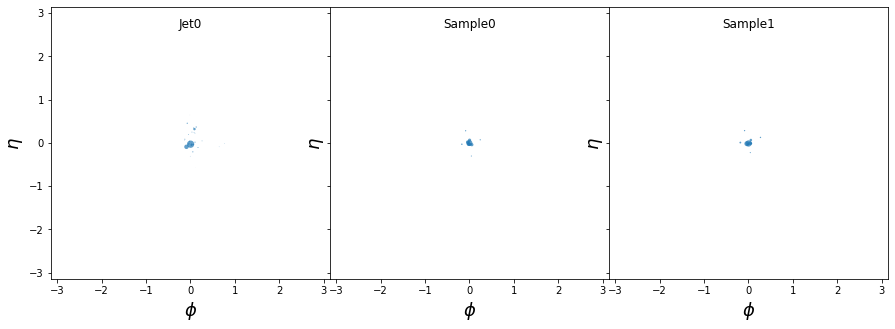

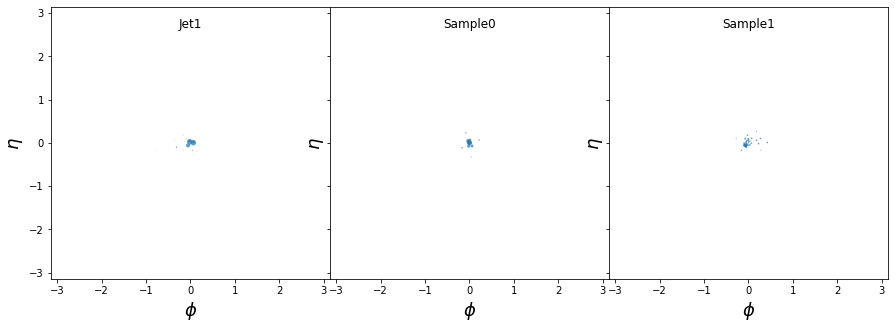

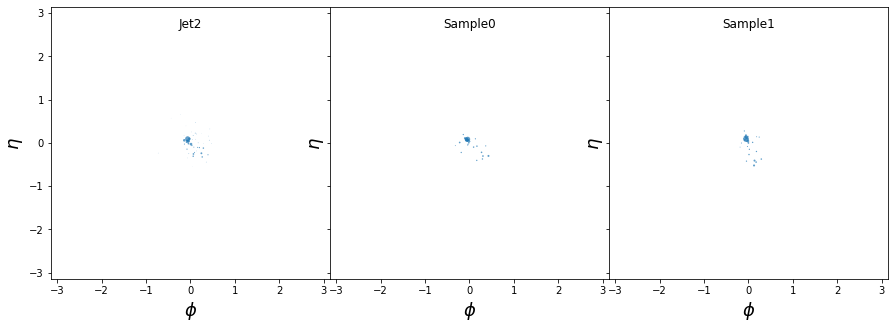

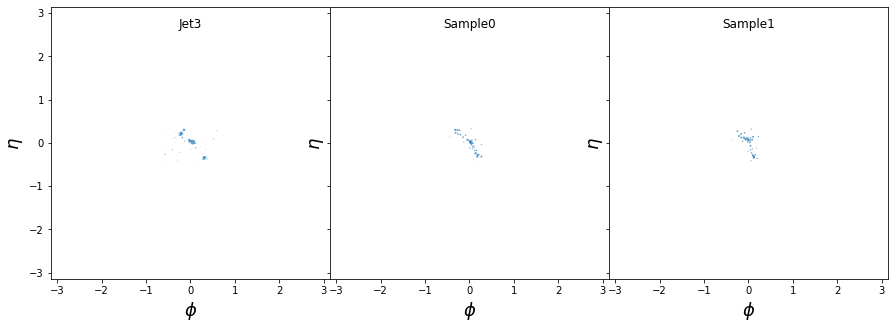

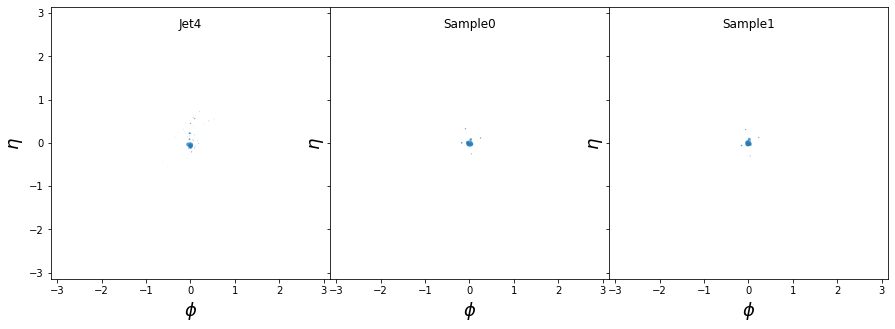

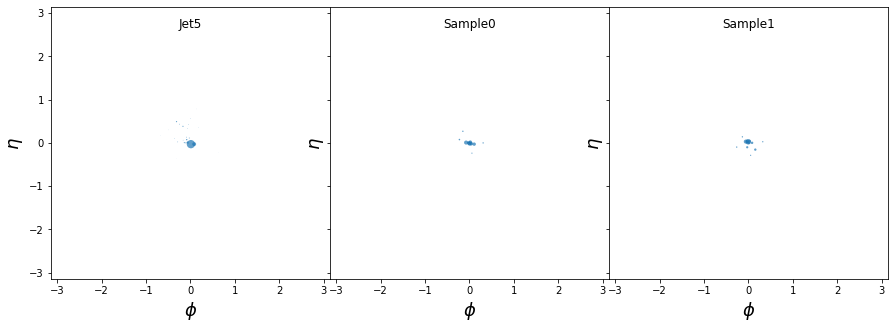

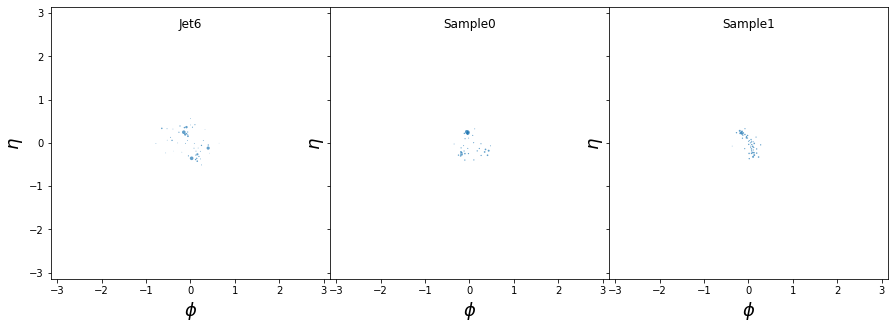

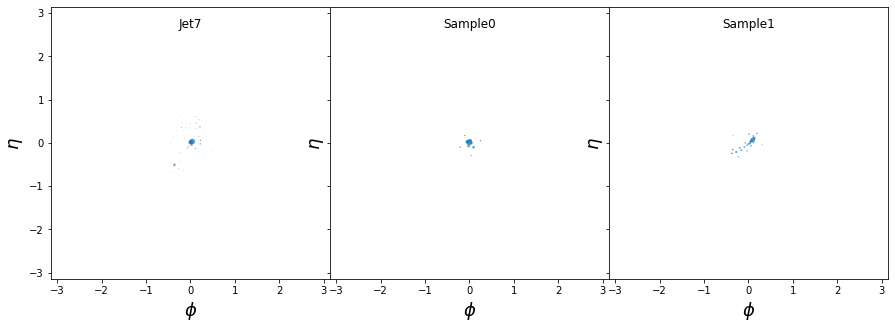

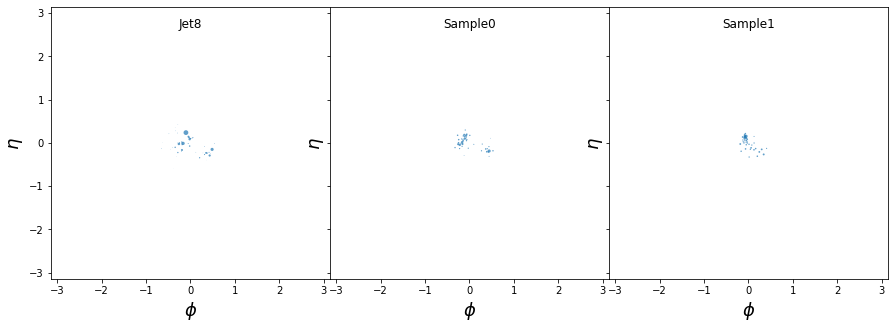

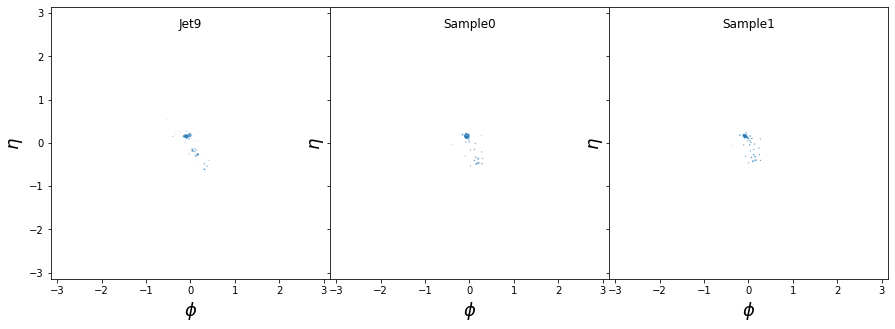

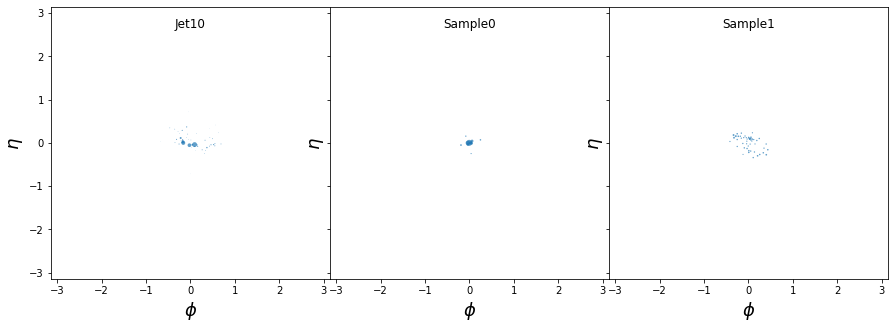

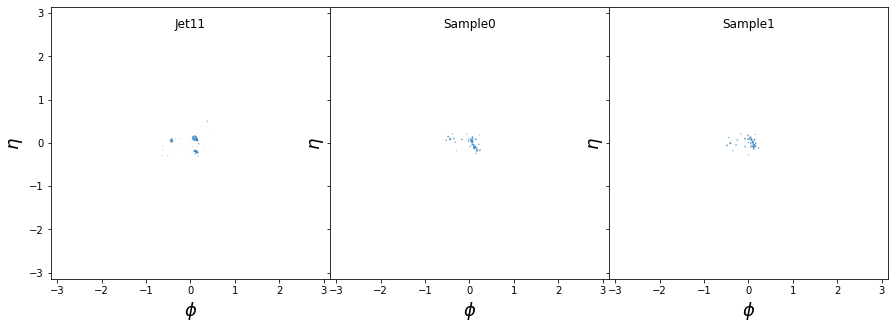

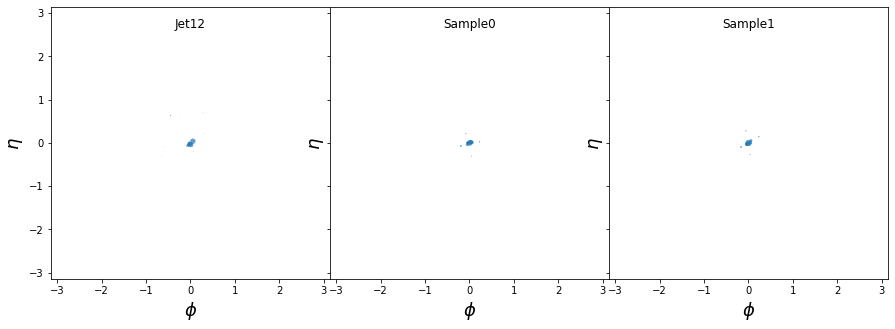

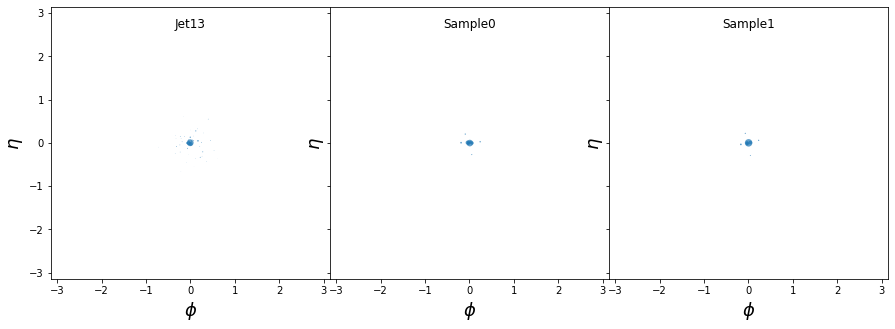

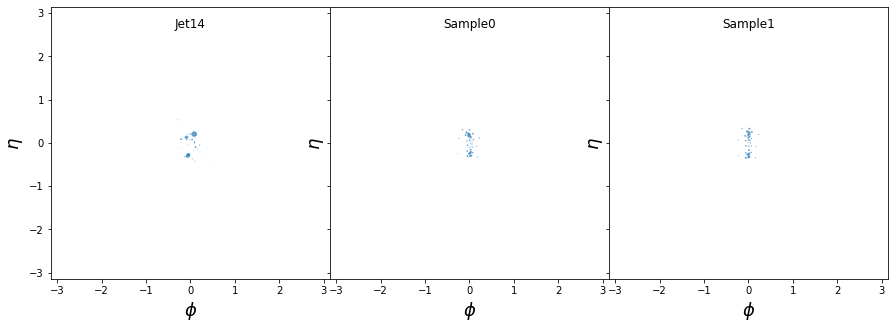

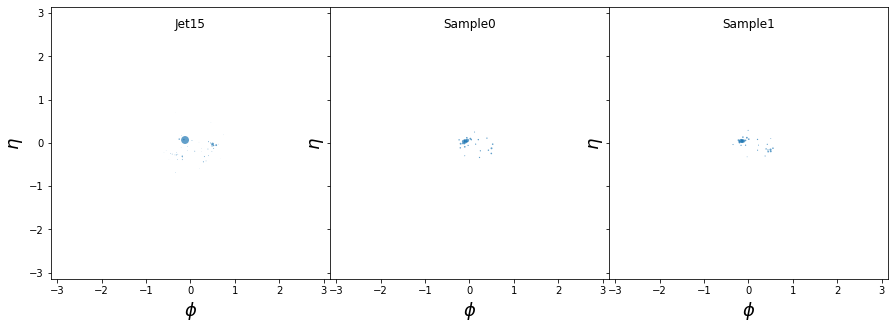

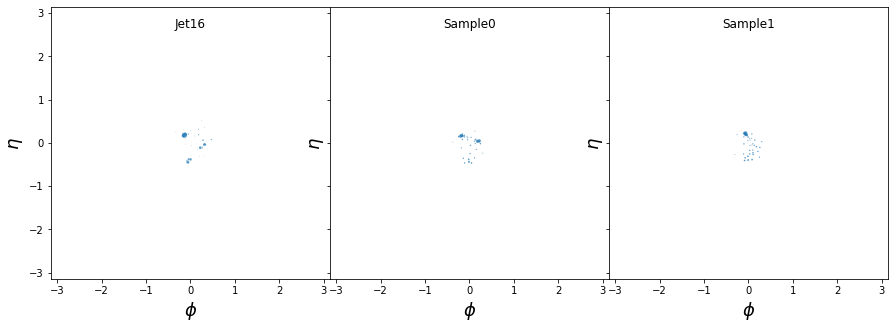

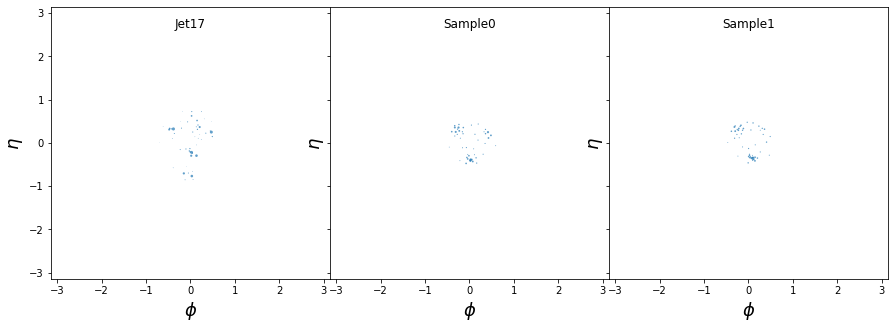

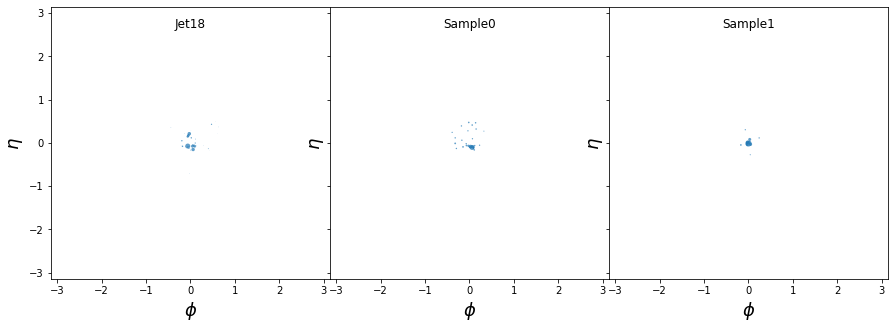

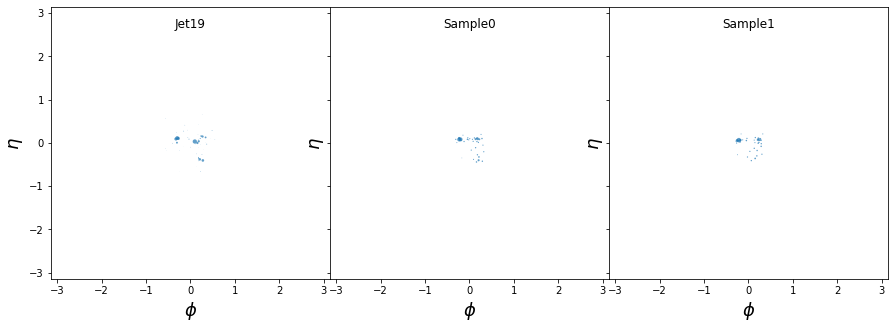

Latent space distributions in most important latent space directions
[(0, 0.7287514947016871), (1, 1.1139658321989239), (2, 0.7682062361778774), (3, 0.9446048805538529), (4, 0.5459088481033527), (5, 1.0475086532090336), (6, 1.3257669234784033), (7, 0.4364125802777381), (8, 0.19547335090552487), (9, 0.7397729861816535), (10, 0.3150763748380543), (11, 2.04040276138622), (12, 1.1287893866280285), (13, 1.282317356679537), (14, 1.5689571263325615), (15, 1.0254786289129405), (16, 1.0145742646077736), (17, 0.9370641746542052), (18, 0.013207848845462333), (19, 1.3811945055314845)]
[(0, 0.10257263), (1, 0.06098928), (2, 0.096972354), (3, 0.92388564), (4, 0.13469575), (5, 0.06645499), (6, 0.95323384), (7, 0.16057396), (8, 0.25093573), (9, 0.8990319), (10, 0.1983219), (11, 0.9796938), (12, 0.059843462), (13, 0.04934021), (14, 0.9651044), (15, 0.06839353), (16, 0.93062204), (17, 0.92311364), (18, 0.43003836), (19, 0.95629734)]


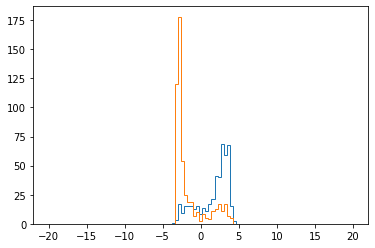

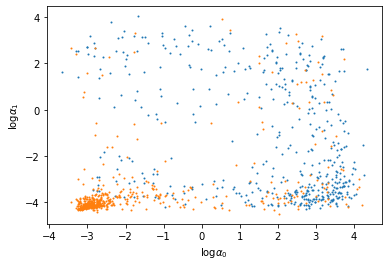

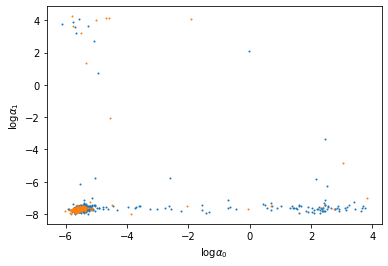

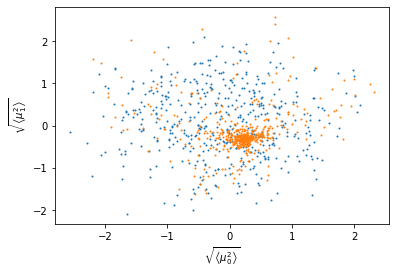

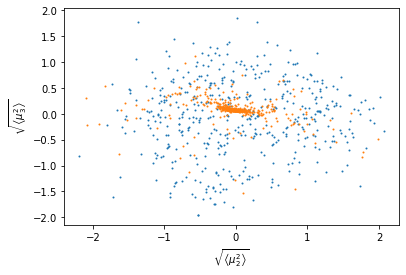

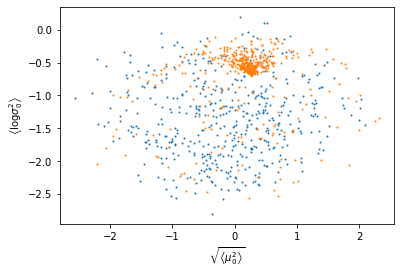

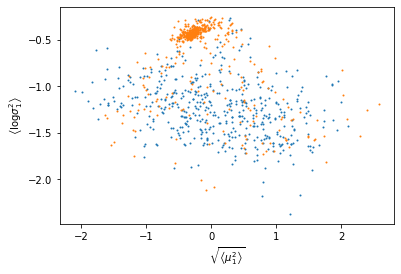

In [11]:
outs_array = [vae.predict(train_x[:1000]) for j in range(3)]

tops = labels[:1000] == 1
js = labels[:1000] == 0

# vae.beta.assign(5e-3)
result = vae.test_step([train_x[:1000].astype(np.float32),train_y[:1000].astype(np.float32)])

print("Loss:", "{:.02e}".format(result['loss'].numpy()))
print("Recon loss:", "{:.02e}".format(result['recon_loss'].numpy()))
print("KL loss:", result['KL loss'].numpy())

print()



print("KL divergences plot. x axis is ~ log(resolution) for resolution << 1")
sort_kl, sort_kl_bern = plot_KL_logvar(outs_array,[-0.1,None],[-0.1,None],showhist=True,numhists=20,hist_ylim=None,hist_xlim=[0,8])
plt.show()

print("Jet sample plots. Left = original jet. Middle and right: two vae samples")
plot_jets(outs_array,injets = train_y[:1000],R=0.02,size=100,numplot=20,lim=3.14)

print("Latent space distributions in most important latent space directions")

if use_vm:
  y_pred ,z_mean, z_log_var, losses, _ = outs_array[0]
  KL = losses
elif use_cat:
  y_pred ,z_mean, z_log_var, _, log_alpha_bern, _ = outs_array[0]
  KL = np.concatenate((kl_loss(z_mean, z_log_var),kl_loss_bern(log_alpha_bern,a)),axis=-1)
else:
  y_pred ,z_mean, z_log_var, _ = outs_array[0]
  KL = kl_loss(z_mean, z_log_var)

def lab_to_p(lab):
    alpha = np.exp(lab)
    return alpha / (1+alpha)

print(list(enumerate(kl_loss_bern(log_alpha_bern,a)[:20,sort_kl_bern[0]])))
print(list(enumerate(lab_to_p(log_alpha_bern)[:20,sort_kl_bern[0]])))

# sort_kl_bern = np.argsort(np.mean(kl_loss_bern(log_alpha_bern,a),axis=0))

plt.hist(log_alpha_bern[tops,sort_kl_bern[0]],bins = np.linspace(-20,20,100),histtype='step')
plt.hist(log_alpha_bern[js,sort_kl_bern[0]],bins = np.linspace(-20,20,100),histtype='step')
# plt.xlabel(r'$\log \alpha_0$')
# plt.ylabel(r'$\log \alpha_1$')
plt.show()

plt.scatter(log_alpha_bern[tops,sort_kl_bern[0]],log_alpha_bern[tops,sort_kl_bern[1]],s=1.)
plt.scatter(log_alpha_bern[js,sort_kl_bern[0]],log_alpha_bern[js,sort_kl_bern[1]],s=1.)
plt.xlabel(r'$\log \alpha_0$')
plt.ylabel(r'$\log \alpha_1$')
plt.show()

plt.scatter(log_alpha_bern[tops,sort_kl_bern[2]],log_alpha_bern[tops,sort_kl_bern[3]],s=1.)
plt.scatter(log_alpha_bern[js,sort_kl_bern[2]],log_alpha_bern[js,sort_kl_bern[3]],s=1.)
plt.xlabel(r'$\log \alpha_0$')
plt.ylabel(r'$\log \alpha_1$')
plt.show()

plt.scatter(z_mean[tops,sort_kl[0]],z_mean[tops,sort_kl[1]],s=1.)
plt.scatter(z_mean[js,sort_kl[0]],z_mean[js,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.show()

plt.scatter(z_mean[tops,sort_kl[2]],z_mean[tops,sort_kl[3]],s=1.)
plt.scatter(z_mean[js,sort_kl[2]],z_mean[js,sort_kl[3]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_2^2 \right\rangle}$')
plt.ylabel(r'$\sqrt{\left\langle \mu_3^2 \right\rangle}$')
plt.show()

plt.scatter(z_mean[tops,sort_kl[0]],z_log_var[tops,sort_kl[0]],s=1.)
plt.scatter(z_mean[js,sort_kl[0]],z_log_var[js,sort_kl[0]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_0^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_0^2 \right\rangle$')
plt.show()
plt.scatter(z_mean[tops,sort_kl[1]],z_log_var[tops,sort_kl[1]],s=1.)
plt.scatter(z_mean[js,sort_kl[1]],z_log_var[js,sort_kl[1]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_1^2 \right\rangle$')
plt.show()

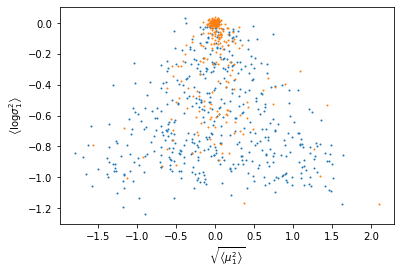

In [18]:
plt.scatter(z_mean[tops,sort_kl[3]],z_log_var[tops,sort_kl[3]],s=1.)
plt.scatter(z_mean[js,sort_kl[3]],z_log_var[js,sort_kl[3]],s=1.)
plt.xlabel(r'$\sqrt{\left\langle \mu_1^2 \right\rangle}$')
plt.ylabel(r'$\left\langle \log \sigma_1^2 \right\rangle$')
plt.show()

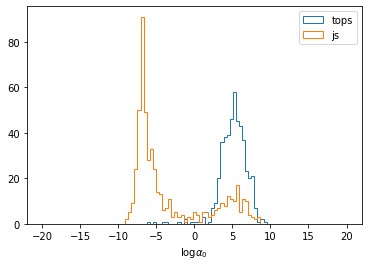

In [16]:
plt.hist(log_alpha_bern[tops,sort_kl_bern[0]],bins = np.linspace(-20,20,100),histtype='step',label='tops')
plt.hist(log_alpha_bern[js,sort_kl_bern[0]],bins = np.linspace(-20,20,100),histtype='step',label='js')
plt.legend()
plt.xlabel(r'$\log \alpha_0$')
# plt.ylabel(r'$\log \alpha_1$')
plt.show()

In [ ]:
np.mean(kl_loss_bern(log_alpha_bern,a),axis=0)[sort_kl_bern]

array([0.8094077 , 0.72904526, 0.72694423, 0.67142357, 0.66406191,
       0.57891058, 0.47041415, 0.43236906, 0.40305308, 0.39604992,
       0.04173994, 0.00205369, 0.00204341, 0.00198766, 0.00181351,
       0.00170398, 0.00165384, 0.00156612, 0.00152671, 0.00145887,
       0.00143985, 0.00129113, 0.00122015, 0.00121182, 0.00114211,
       0.00110274, 0.00106955, 0.00099269, 0.00099114, 0.00093376,
       0.0008753 , 0.00085534])

In [85]:
a[sort_kl_bern]

array([0.69254144, 0.14011102, 0.37744494, 0.50340739, 1.        ,
       0.28906081, 0.22475001, 0.07221304, 0.17670858, 0.1118133 ,
       0.08968033, 0.04723359, 0.001001  , 0.00122347, 0.00149546,
       0.00223472, 0.00182803, 0.00334064, 0.00499658, 0.00273214,
       0.00747949, 0.00408522, 0.00611249, 0.0137325 , 0.00915497,
       0.05833001, 0.01683212, 0.01120996, 0.03114587, 0.02064563,
       0.02534467, 0.03832454])